# __COMPUTATION II: ALGORITHMS & DATA STRUCTURES__

# PROJECT

Group Name:Group 21

Group Members: Gonçalo Faustino, Miguel Pires, Bernardo Coelho

Student Numbers: 20231721 , 20231736 , 20231718

--------------------------
**Don't change or modify the order and titles of this notebook.** However, feel free to add as many cells as you want between sections. 

Good luck!

# Section 1: Dataset

Read and store the dataset file provided to you (`sales_dataset_group_<X>.pkl`).

Store the dataset under the variable name `dataset`.

In [6]:
import pickle
import timeit
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


with open("sales_dataset_group_21.pkl", "rb") as data:
    dataset = pickle.load(data)


# Section 2: Fixing problems in the dataset

Fix here any problems you may find in the dataset while you're developing the project. 

**Do not modify the dataset anywhere else except in this section!**

In [8]:
# creating a name list for the purpose of seeing errors in name spelling
def get_names(data_list):
    unique_names = []
    for data in data_list:
        name = data["Name"]
        if name not in unique_names:
            unique_names.append(name)
    return unique_names

# creating a price list for purposes of fixing errors in price setting
def price_list(dataset):
    price_list = {}
    for data in dataset:
        item = data["Item"]
        unit_price = data["Unit Price"]
        if isinstance(unit_price, (int, float)):
            if not isinstance(item, (int, float)):
                if item not in price_list:
                    price_list[item] = unit_price
    return price_list

print(price_list(dataset))
#reference prices for each article for error purpose

{'donation_voucher': 7, 'beer': 1.2, 'pen': 2.5, 'flash_drive': 5, 'notebook': 3, 'tshirt': 15, 'hoodie': 27, 'party_ticket': 9, 'chocolate': 1.5, 'game_ticket': 6.5, 'coffee': 0.6, 'water': 0.3, 'snack_pack': 1.3, 'water_bottle': 0.8, 'printing': 0.2, 'lecture_notes': 2.3, 'photocopy': 0.3, 'concert_ticket': 10}


# Section 3: Extraction of Information

### Extraction of recency, frequency and monetary values

In [9]:
#function that retrieves a list of the data for each costumer, input the name as a string
def costumer_data_function(name):
    costumer_data = []
    for i in dataset:
        if i["Name"].lower() == name.lower():
            costumer_data.append(i)
    return costumer_data

#function that retrieves the last purchase date and the number of days since the last purchase, input the name as a string
def lastpurchasedate(name):
    costumer_data = costumer_data_function(name)
    last_purchase_date = costumer_data[0]["Date"]
    for data in costumer_data:
        if data["Date"] > last_purchase_date:
            last_purchase_date = data["Date"]
    
    last_purchase_datetime = datetime.strptime(last_purchase_date, '%Y-%m-%d')
    reference_datetime = datetime.strptime('2024-03-01', '%Y-%m-%d')
    days_passed = (reference_datetime - last_purchase_datetime).days
    
    return last_purchase_date, days_passed

# dictionary with costumer name as key and days since last purchase as value
recency = {}
for data in dataset:
    name = data["Name"]
    last_purchase_date, days_passed = lastpurchasedate(name)
    recency[name] = days_passed

#function that retrieves the number of purchases for each student, input the name as a string
def numberofpurchases(name):
    costumer_data = costumer_data_function(name)
    return len(costumer_data)

#dictionary to store the number of purchases for each student
frequency = {}
for data in dataset:
    name = data["Name"]
    if name in frequency:
        frequency[name] += 1
    else:
        frequency[name] = 1
        
#function that retrieves the total amount spent by each student, input the name as a string
def totalamountspent(name):
    costumer_data = costumer_data_function(name)
    total = 0
    error = 0
    for i in costumer_data:
        unit_price = i["Unit Price"]
        item = i["Item"]
        if isinstance(unit_price, (int, float)):
            total += unit_price * i["Quantity"]
        elif isinstance(unit_price, str) and unit_price in price_list(dataset):
            total += price_list(dataset)[unit_price] * i["Quantity"]
        else:
            error += 1
            print(f"Error: Invalid unit price '{unit_price}' for item '{i['Item']}'")

    print(f"There were {error} errors found in the data.")
    return total

#dictionary to store the total amount spent by each student
monetary_value = {}

for data in dataset:
    name = data["Name"]
    unit_price = data["Unit Price"]
    quantity = data["Quantity"]
    
    if isinstance(unit_price, (int, float)):
        value = unit_price * quantity
    elif isinstance(unit_price, str) and unit_price in price_list(dataset):
        value = price_list(dataset)[unit_price] * quantity
    else:
        value = 0
    if name in monetary_value:
        monetary_value[name] += value
    else:
        monetary_value[name] = value


### Histograms

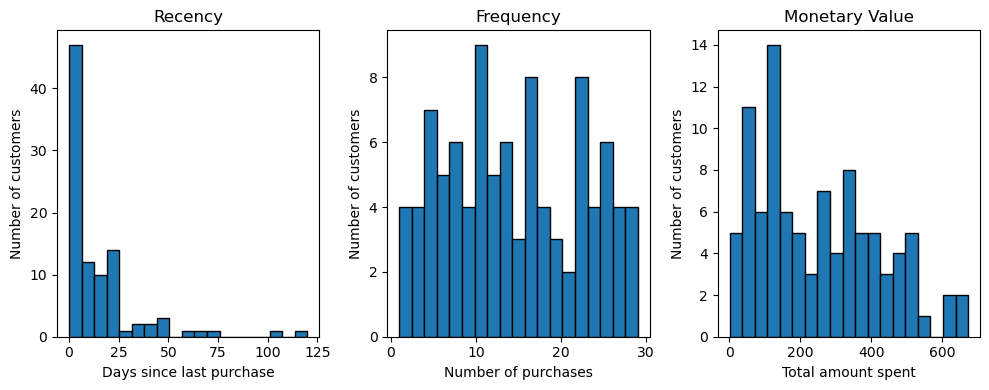

In [15]:

#recency graph
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.hist(list(recency.values()), bins=len(recency.values())//5, edgecolor='black') 
plt.xlabel('Days since last purchase')
plt.ylabel('Number of customers')
plt.title('Recency')

#frequency graph
plt.subplot(1, 3, 2)
plt.hist(list(frequency.values()), bins=len(recency.values())//5, edgecolor='black')  
plt.xlabel('Number of purchases')
plt.ylabel('Number of customers')
plt.title('Frequency')

#monetary value graph
plt.subplot(1, 3, 3)
plt.hist(list(monetary_value.values()), bins=len(recency.values())//5, edgecolor='black')
plt.xlabel('Total amount spent')
plt.ylabel('Number of customers')
plt.title('Monetary Value')

plt.tight_layout()
plt.show()

# Section 4: Sorting

### First RFM scores (RFM)

In [16]:
def merge(left, right): #merge function for merge sort
    output = []
    i = j = 0
    while i < len(left) and j < len(right):
        if left[i][1] < right[j][1]:  # compare second element of tupple
            output.append(left[i])
            i += 1
        else:
            output.append(right[j])
            j += 1
    return [*output, *left[i:], *right[j:]]

def merge_sort(seq):
    if len(seq) == 1:
        return seq
    
    idx_half = len(seq) // 2
    right = merge_sort(seq[idx_half:])
    left = merge_sort(seq[:idx_half])
    return merge(left, right)


#function that gives scores to the students based on the sorted items
#adding 2 because of errors in the division of the length
def give_scores(sorted_items):
    length = len(sorted_items)
    third_size = (length + 2) // 3 
    
    scores = {}
    for i, (student, _) in enumerate(sorted_items):
        if i < third_size:
            scores[student] = 3
        elif i < 2 * third_size:
            scores[student] = 2
        else:
            scores[student] = 1
    return scores


#sorting recency
itemsrecency = list(recency.items())
sorted_recency = merge_sort(itemsrecency)
sorted_recency = sorted_recency[::-1]
#giving score
recency_scores = give_scores(sorted_recency)


#sorting frequency
itemsfrequency = list(frequency.items())
sorted_frequency = merge_sort(itemsfrequency)
sorted_frequency = sorted_frequency[::-1]
#giving score
frequency_scores = give_scores(sorted_frequency)


#sorting monetary value
itemsmonetary_value = list(monetary_value.items())
sorted_monetary_value = merge_sort(itemsmonetary_value)
sorted_monetary_value = sorted_monetary_value[::-1]
#giving score
monetary_value_scores = give_scores(sorted_monetary_value)


- Can you determine which students are most valuable to our SU, considering that our
organization is evil and values students solely based on their purchase history?

Answer: 

In [32]:
final_scores = {}

for student in recency_scores:
    final_scores[student] = str(recency_scores[student]) + str(frequency_scores[student]) + str(monetary_value_scores[student])

items = list(final_scores.items())
final_scores_sorted = merge_sort(items)

final_scores_sorted = final_scores_sorted[::-1]

#tranlaste to dictionary
rfm1 = {}
for i in final_scores_sorted:
    rfm1[i[0]] = i[1]

#The most valuable customers are the ones with the highest score (333),
# the least valuable are the ones with the lowest score(111).

### Second RFM Scores (RFM')

In [34]:
def nested_bucket_sort(recency_scores, frequency_scores, monetary_value_scores):
    all_scores = {}
    for recency_score in [3, 2, 1]:
        current_bucket = [student for student in recency_scores if recency_scores[student] == recency_score]
        
        frequency_sorted_bucket = merge_sort(current_bucket)[::-1] 
        frequency_scores_current = give_scores([(student, frequency_scores[student]) for student in frequency_sorted_bucket])
        
        for frequency_score in [3, 2, 1]:
            current_frequency_bucket = [student for student in frequency_scores_current if frequency_scores_current[student] == frequency_score]
            
            monetary_sorted_bucket = merge_sort(current_frequency_bucket)[::-1] 
            monetary_scores_current = give_scores([(student, monetary_value_scores[student]) for student in monetary_sorted_bucket])
            
            for student in monetary_scores_current:
                r = recency_scores[student]
                f = frequency_scores_current[student]
                m = monetary_scores_current[student]
                all_scores[student] = f"{r}{f}{m}"
                
    return all_scores

#genrate RFM scores
rfm_scores = nested_bucket_sort(recency_scores, frequency_scores, monetary_value_scores)

#sort rfm 2
rfm2 = [(student, score) for student, score in rfm_scores.items()]
sorted_rfm2 = merge_sort(rfm2)[::-1] 

### Correlation

In [35]:
# extract scores from final_scores_sorted and sorted_rfm2
rfm_scores_list = [int(score) for _, score in final_scores_sorted]
rfm2_scores_list = [int(score) for _, score in sorted_rfm2]

# calculate Spearman coefficient
correlation_coefficient, p_value = spearmanr(rfm_scores_list, rfm2_scores_list)

print(f"Spearman Rank Correlation Coefficient: {correlation_coefficient}")

#spearman is 0,9947 which is very close to 1, which means that the two lists are very similar



Spearman Rank Correlation Coefficient: 0.994747005021128


# Section 5: Searching

### Linear Search

In [36]:
group_scores = {}
group = ["Gonçalo","Bernardo","Miguel"]

def linear_search(list, target):
   for student, score in final_scores_sorted:
         if student == target:
            return score
         
for student in group:
      group_scores[student] = linear_search(final_scores_sorted, student)

group_scores

{'Gonçalo': '233', 'Bernardo': '323', 'Miguel': '221'}

- Who do you think is the best student/customer among your group?

Answer:

In [37]:
#The best student is Bernardo as he has the highest score, the worst student is Miguel as he has the lowest score.

### Alphabetical Sorting

In [40]:
def merge_sort_dict(dictionary):
    if len(dictionary) <= 1:
        return dictionary
    
    mid = len(dictionary) // 2
    left_dict = merge_sort_dict(dict(list(dictionary.items())[:mid]))
    right_dict = merge_sort_dict(dict(list(dictionary.items())[mid:]))
    
    return merge_dicts(left_dict, right_dict)

def merge_dicts(left_dict, right_dict):
    merged_dict = {}
    left_keys = list(left_dict.keys())
    right_keys = list(right_dict.keys())
    i = j = 0
    
    while i < len(left_keys) and j < len(right_keys):
        if left_keys[i] < right_keys[j]:
            merged_dict[left_keys[i]] = left_dict[left_keys[i]]
            i += 1
        else:
            merged_dict[right_keys[j]] = right_dict[right_keys[j]]
            j += 1
    
    while i < len(left_keys):
        merged_dict[left_keys[i]] = left_dict[left_keys[i]]
        i += 1
    
    while j < len(right_keys):
        merged_dict[right_keys[j]] = right_dict[right_keys[j]]
        j += 1
    
    return merged_dict

sorted_dictionary = merge_sort_dict(final_scores)

### Binary Search

In [41]:
def binary_search(names, target):
    left, right = 0, len(names) - 1
    while left <= right:
        mid = (left + right) // 2
        if names[mid] == target:
            return mid
        elif names[mid] < target:
            left = mid + 1
        else:
            right = mid - 1
    return -1


dictionary = list(sorted_dictionary.items())
group_scores_binary = []    

for student in group:
    binary_search([student for student, _ in dictionary], student)
    group_scores_binary.append(dictionary[binary_search([student for student, _ in dictionary], student)])



- How much time, in terms of seconds, did it take to find a name using linear search and
binary search? Compare the results. (You can use the timeit module.)

Answer:

In [42]:
print(timeit.timeit('binary_search([student for student, _ in dictionary], "Miguel")', globals=globals(), number=20000)) # binary search
print(timeit.timeit('linear_search(final_scores_sorted, "Miguel")', globals=globals(), number=20000)) # linear search


#The binary search is faster than the linear search as it has a time complexity of O(log n) while the linear search has a time complexity of O(n).

0.20397949987091124
0.08502699993550777


---------------------

Great job, congrats!